# Learning Models

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [2]:
#number of top films to keep in my dataset
num_top_films_for_model = 100
#number of movies to get top directors and writers
cream_of_the_crop = 50

In [3]:
movies = pd.read_csv("../data/movies.csv")

#getting the top 10000 films of all time
movies = movies.sort_values(by=['score'], ascending=False).head(num_top_films_for_model)

In [4]:
#getting the writers and directors from the top 250 films of all time. 
#These are the top 1% of Hollywood and they are the only ones that matter
best_directors = movies.sort_values(by=['score', 'directors'], ascending=False).head(cream_of_the_crop)['directors'].unique().tolist()
best_writers = movies.sort_values(by=['score', 'writers'], ascending=False).head(cream_of_the_crop)['writers'].unique().tolist()

#the bottom 99% will do into these replaceable lists
replacable_directors = []
replacable_writers = []

for x in movies['directors']:
    if x not in best_directors:
        replacable_directors.append(x)
        
for x in movies['writers']:
    if x not in best_directors:
        replacable_writers.append(x)       

In [5]:
#replacing the bottom 99% 's unique ID number with 'unknown'
#this will help when getting dummies
movies.replace(replacable_directors, 'unknown', inplace=True)
movies.replace(replacable_writers, 'unknown', inplace=True)

In [6]:
#get dummies for: genres directors, writers
genre_dummies = pd.get_dummies(movies['genres'])
director_dummies = pd.get_dummies(movies['directors'])
writer_dummies = pd.get_dummies(movies['writers'])

frames = [movies['startYear'], genre_dummies, director_dummies, writer_dummies, movies['runtimeMinutes'], movies['averageRating']]

### Getting DataFrame Ready for ML

In [7]:
#creating a ready for model df that has only the relavant features and target
ready_for_model = pd.concat(frames, axis=1)
ready_for_model = ready_for_model.drop(['unknown'], axis=1)

## Regression Models
Imports, TT splits, and functions to output  model RMSEs and baseline RMSE

Ran LinearRegression() , GradientBoostingRegressor(), and RandomForestRegressor()

In [8]:
import sklearn.model_selection as sk
import sklearn.metrics as sk
import sklearn.ensemble as ske


### Train Test Split

In [9]:
#features are: year, genre dummies, writer/director dummies, runtime
X = ready_for_model.drop(['averageRating'], axis=1)
#target is: average rating
y = ready_for_model['averageRating']
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Functions to output model RMSEs and baseline RMSE

In [10]:
#function that does the following:
#train test split, fit, and prediction
#measures model with rmse
#prints model name and rmse
def regression_model(X, y, my_model):
    model = my_model
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    rmse = sk.mean_squared_error(y_test,predicted)
    return rmse
#     print("Model: {}".format(model))
#     print("RMSE: {}".format(rmse))
#     print()
        
    
#java style getter method to get baseline rmse
def get_baseline_rmse(df):
    set_mean = df['averageRating'].mean()
    df['error'] = df['averageRating'] - set_mean
    summation = 0
    for x in df['error']:
        summation += x**2
    
    return (summation/df['error'].size)**(0.5)

#     print('Baseline RMSE: {}'.format((summation/df['error'].size)**(0.5)))

In [12]:
regression_model(X, y, LinearRegression())
regression_model(X, y, ske.GradientBoostingRegressor())
regression_model(X, y, ske.RandomForestRegressor())
get_baseline_rmse(ready_for_model)

0.31577840331472984

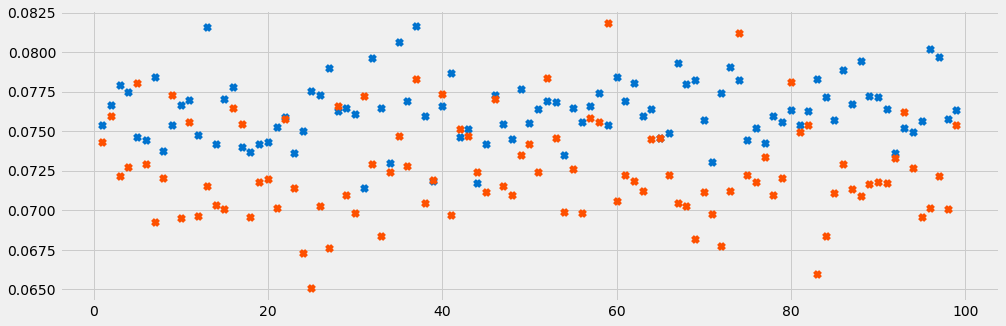

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))

x = list(range(1, 100))

for run in x:
    y = regression_model(X, y, ske.GradientBoostingRegressor())
    z = regression_model(X, y, ske.RandomForestRegressor()) 
    ax.scatter(run, y, color='#0072CE', marker = 'x', label = "Gradient Boosting Regressor")
    ax.scatter(run, z, color='#FE5000', marker = 'x', label = "Random Forest Regressor")
    
    